In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import os, glob, json
import config as cfg
from IPython.display import display
from ipywidgets import widgets, Layout
from module.relgan_d import RelSpaceGAN_D
from module.cluster import Cluster
from module.relgan_g import RelSpaceG
from dataset import TextSubspaceDataset, seq_collate
from constant import Constants
from utils import get_fixed_temperature, get_losses
from sklearn.cluster import KMeans
import numpy as np
from tensorboardX import SummaryWriter
from utils import gradient_penalty, str2bool, chunks
from sklearn.manifold import SpectralEmbedding
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from shutil import copyfile
import pickle
from collections import namedtuple

In [7]:
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [19]:
log_name = 'save/subrelgan-gp-kmeans-2020-04-08-05-55-22'
iteration = 1000
K_BINS = 20
checkpoint_name = 'relgan_G_{}.pt'.format(iteration)

In [20]:
assert os.path.exists(os.path.join(log_name, 'relgan_g.py')) == True
assert os.path.exists(os.path.join(log_name, checkpoint_name)) == True

copyfile(os.path.join(log_name, 'relgan_g.py'), 'module/temp_g.py')
from module.temp_g import RelSpaceG
checkpoint = torch.load(os.path.join(log_name, checkpoint_name))
# checkpoint should contain model state dict,
assert len(checkpoint) == 3
with open(os.path.join(log_name, 'params.json'), 'r') as f:
    params = json.load(f)
args = Struct(**params)

p = checkpoint['p']
latent = checkpoint['latent']
dataset = TextSubspaceDataset(-1, 'data/kkday_dataset/train_title.txt', prefix='train_title', embedding=None, 
    max_length=args.max_seq_len, force_fix_len=args.grad_penalty or args.full_text, k_bins=K_BINS, token_level=args.tokenize)
dataset.p = p
dataset.latent = latent
dataloader = torch.utils.data.DataLoader(dataset, num_workers=4,
                collate_fn=seq_collate, batch_size=args.batch_size, shuffle=True)
model = RelSpaceG(args.mem_slots, args.num_heads, args.head_size, args.gen_embed_dim, 
        args.gen_hidden_dim, dataset.vocab_size,
        k_bins=K_BINS, latent_dim=args.gen_latent_dim, noise_dim=args.gen_noise_dim,
        max_seq_len=args.max_seq_len-1, padding_idx=Constants.PAD, gpu=True)

model.load_state_dict(checkpoint['model'])
model = model.cuda()
model = model.eval()

In [21]:
init_idx = 0
init_latent = latent[init_idx]
bins_slider = [ widgets.FloatSlider(value=init_latent[i],min=latent[:, i].min(), max=latent[:, i].max(), step=0.1, description='bin-{}'.format(i)) for i in range(K_BINS) ]

display(widgets.HTML(
    value="<br><h3> Play with latent feature </h3> ",
))
for slider in bins_slider:
    display(slider)


HTML(value='<br><h3> Play with latent feature </h3> ')

FloatSlider(value=-1.1459346062308682, description='bin-0', max=15.492585674727687, min=-2.505448355265655)

FloatSlider(value=0.18544452105186307, description='bin-1', max=16.985741354562872, min=-10.218551585503882)

FloatSlider(value=0.10935357696551865, description='bin-2', max=16.55065280398624, min=-16.10252537742402)

FloatSlider(value=-1.449555410873142, description='bin-3', max=17.209029787384345, min=-5.831358691699588)

FloatSlider(value=-0.5006789131883659, description='bin-4', max=18.86475697696866, min=-9.117801530508219)

FloatSlider(value=-0.3343904804139407, description='bin-5', max=17.428554658245435, min=-9.836547563265324)

FloatSlider(value=0.9291275495961163, description='bin-6', max=22.11952880708638, min=-11.933126404039713)

FloatSlider(value=-1.749797414098167, description='bin-7', max=14.561279812024612, min=-14.46340701800207)

FloatSlider(value=-2.7306781962545994, description='bin-8', max=14.648870991234888, min=-9.521448554678706)

FloatSlider(value=1.8631313898973347, description='bin-9', max=15.797646888292546, min=-10.30682843554967)

FloatSlider(value=-2.3930286697600884, description='bin-10', max=13.121045220841836, min=-9.509098406339989)

FloatSlider(value=9.014090855635379, description='bin-11', max=22.800511515694488, min=-11.874670183202966)

FloatSlider(value=5.924824713945221, description='bin-12', max=11.411466476505565, min=-10.678222727543119)

FloatSlider(value=0.520219900165486, description='bin-13', max=16.576370891449276, min=-12.87550915591419)

FloatSlider(value=-0.09892492064259147, description='bin-14', max=13.498296300875742, min=-9.775896894246427)

FloatSlider(value=-1.4862626702597919, description='bin-15', max=15.43072014680294, min=-12.748411691460513)

FloatSlider(value=-0.999282652738437, description='bin-16', max=15.246294368463234, min=-11.208217345719968)

FloatSlider(value=0.4412534232347893, description='bin-17', max=27.243617786136706, min=-7.5497452920886055)

FloatSlider(value=-1.408317607965634, description='bin-18', max=22.70156204611232, min=-13.13339995350316)

FloatSlider(value=3.893719072508225, description='bin-19', max=18.240608421895416, min=-6.758710446310465)

In [23]:
print(init_latent)

[-1.14593461  0.18544452  0.10935358 -1.44955541 -0.50067891 -0.33439048
  0.92912755 -1.74979741 -2.7306782   1.86313139 -2.39302867  9.01409086
  5.92482471  0.5202199  -0.09892492 -1.48626267 -0.99928265  0.44125342
 -1.40831761  3.89371907]


In [1]:
import pickle
with open('latent_variable_20.pkl', 'rb') as f:
    latents = pickle.load(f)
print(latents[0])

[-0.40110661  0.053731    0.02041557 -0.49952886 -0.1492657  -0.04508191
  0.28627305 -0.60933987 -0.83062814  0.60365014 -0.14524659  2.80684088
  2.81072806  0.21474031 -0.14883904 -0.46788561 -0.35034584  0.2746236
 -0.19765725  1.58832746]


In [12]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [132]:
iter_ = 1000
with open(f'logs/vae_gumbel/cluster_{iter_}.pkl', 'rb') as f:
    clusters = pickle.load(f)

In [133]:
X, title = [], []
for key, latent in clusters.items():
    X.append(latent)
    title.append(key)
title = np.array(title)

In [134]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

No handles with labels found to put in legend.


explained variance ratio (first two components): [0.39433594 0.22087259]


Text(0.5, 1.0, 'PCA of clutser at 3000')

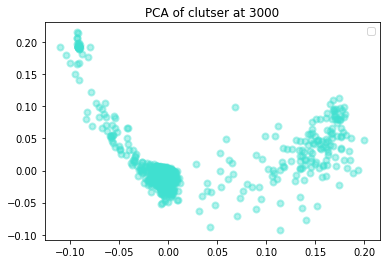

In [135]:
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

plt.scatter(X_r[:, 0], X_r[:, 1], color='turquoise', alpha=.4, lw=lw)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of clutser at 3000')

In [136]:
from sklearn.cluster import DBSCAN
nbrs = DBSCAN(eps=3, min_samples=2).fit(X_r)
y = nbrs.labels_
print(set(y))

{0}


In [156]:
from sklearn.cluster import SpectralClustering
nbrs = SpectralClustering(n_clusters=6).fit(X_r)
y = nbrs.labels_
print(set(y))

{0, 1, 2, 3, 4, 5}


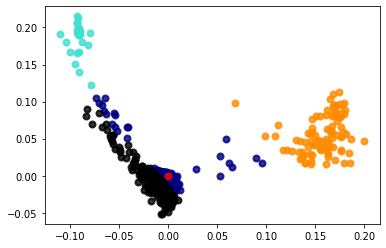

In [162]:
plt.figure()
target_names = [0,1,2,3,4]

colors = ['navy', 'turquoise', 'darkorange','red','black']
lw = 2

for color, i, target_name in zip(colors, list(range(len(target_names))), target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

In [163]:
print(title[y==1][:30])

['【 官方 授權 】 ## ## ## ## ## ／ 快速 ## 通行票' '【 官方 授權 】 ## ## 手環 ## ## ## ##'
 '【 拉 報表 用 】' '【 官方 授權 】 ## ## 特快 入場券 （ 快速 通關 ## ## ） - 小小兵 3'
 '【 官方 授權 】 ## ## 電子 ## ＋ 環球 特快 入場券 （ 快速 通關 ## ## ） - 標準 7'
 '【 官方 授權 】 ## ## ™ ## ＋ 快速 ## 通關'
 '【 官方 授權 】 ## ## 特快 入場券 （ 快速 通關 ## ## ） - 歡樂 好 聲音 7'
 '【 官方 授權 】 豪華 套票 ： ## ## 電子 ## ＋ 豪華 特快 入場券 4 ## 小小兵 ) ＋ 豪華 5000 日幣 購物券'
 '【 官方 授權 】 ## ## 電子 ## ＋ ## 4 G 上網 推薦 ## 5 天 / 8 天 網卡 （ ## ## 取 件 ）'
 '【 官方 授權 】 ## ## ™ ## ＋ 特別版 快速 ## 通關'
 '【 官方 授權 】 ## ## 電子 ## ＋ 環球 特快 入場券 （ 快速 通關 ## ## ） - 標準 6'
 '【 官方 授權 】 ## ## ™ 快速 通關券 - 標準 4 ． 飛天 翼龍 4 ## 1 / 10 起 )'
 '【 城市 景點 隨 你 看 】 ## 觀光 巴士 一日券' '【 造訪 007 電影 場景 】 攀 牙 灣 、 ## ## 一 日 遊'
 '【 官方 接駁車 】 愛 寶 ## 、 ## 直達 接駁車 （ ## 出發 ）'
 '【 官方 授權 套票 】 ## ## ## ## ## ＋ ## ## ##'
 '【 水陸 兩棲 巴士 探索 之 旅 】 ## 城市 觀光 ＋ ## 遊船 體驗'
 '【 官方 授權 】 ## 夜間 ## ## （ ## ## ）' '【 官方 授權 】 ## ## ™ ## 盛夏 ## ##'
 '【 官方 授權 】 ## ## 電子 ## ＋ 環球 特快 入場券 （ 快速 通關 ## ## ） - 標準 4 （ 1 / 10 起 ）'
 '【 騎 機車 饗 美食 】 夜遊 順化 ##' '【 超人 氣 動畫 主題 巴士 】 你 的 名字 ・ 敞篷 咖啡 巴士'
 '【 官方 授權 】

In [164]:
print(title[y==0][:30])

['【 ## 頂級 按摩 】 經典 套餐 獨家 8 </UNK>' '【 ## 最 大 ## 】 </UNK> 時代 ## 主題 ## ##'
 '【 ## ## ## 】 ## 首 ## ## 快 線 ## 單程 車票'
 '【 ## ## 道 循環 巴士 】 臨 ## ## 、 第三 地道 、 都 ## ## 、 ## ## 、 ## ##'
 '【 ## 一 日 遊 】 元 乃 ## ## 、 ## 、 ## 弁 ## 一 日 遊 （ ## 出發 ）'
 '【 免 排隊 快捷 通道 】 三合一 套 票 ： ## 夫人 ## ## 摩天 ## ## 纜車'
 '【 ## 上網 電話卡 】 ## 7 天 ## 卡 500 分鐘 通話 （ ## ## 領取 ）'
 '【 ## 賞 花 一 日 遊 】 ## ## ## 粉蝶 花 之 丘 ・ ## ## 紫藤 花'
 '【 ## ## 露營 二 日 遊 】 ## 國家 ## 、 ## 、 ## ## （ ## 出發 ）'
 '【 超 划算 七 折 優惠 】 ## ## 快 綫 車票 （ ## ## 快速 入閘 ）'
 '【 ## ## 二 日 遊 】 ## ## 小 火車 ・ ## ## ## ・ ## 水壩 ## ## 出發 )'
 '【 ## 必 看 表演 】 ## 奇幻 大秀 ## ## ##' '【 專屬 ## 優質 接送 】 ## ## 包車 接送 （ 雙向 發車 ）'
 '【 ## 4 G 上網 推薦 】 ## 5 天 / 8 天 網卡 （ ## ## 取 件 ）'
 '【 ## 上下 顛倒 屋 】 超值 優惠 ##'
 '【 ## JR PASS 】 ## & ## ## 周遊券 ## （ ## ## 取 件 ）'
 '【 ## 出發 】 ## ## 8 折 優惠 車票 （ ## 限定 電子票 ）'
 '【 頂級 法式 自助餐 】 ## 十六 ## 海風 ## 自助餐' '沒有 ## 的 ## ！ ## ## ## 一 日 遊'
 '【 ## 必備 ## 票券 】 ## 八達通 交通卡' '【 ## ## 出發 】 ## 高鐵票 8 折 優惠 （ ## 限定 電子票 ）'
 '【 ## 鐵道 自行車 】 ## 鐵道 ## ## 電子 ##'
 '【 ## 純淨 ## 6 日遊 】 造訪 ## 最 美 冰川

In [165]:
print(title[y==2][:30])

['## 包車 一 日 遊 ． 暢遊 經典 ## 8 小時' '## 音樂劇 ## ． ##' '## ## 愛 3 ## ## ##'
 '63 ## ## － ## 藝術城 ##' '## 出發 ) ## 包車 一 日 遊' '## 夜間 意式 薄餅 遊船 之 旅'
 '## 愛 寶 ## 電子 ## （ ## ## ）' '## ## 自然 之 旅 1 日 遊'
 '專車 小包團 ) （ 5 天 4 夜 玩 轉 ## 特製 團 ）'
 '## 周遊卡 ## ## PASS 1日券 / 2日券 （ ## ## 取 件 ）' '## ## ## 盛事 ## 自助 午餐 ／ 晚餐'
 '## 包車 ． 探索 ## 的 秘密 半 日遊' '## ## 國家 ## 一 日 遊 （ ## ## ## 來回 ）'
 '## ． </UNK> 活 一 日 遊' '## ## 紫蝶 ## 精彩 一 日 遊'
 '## ## 8 ## － ## 神秘 小 ## ． 春天 ## 神奇' '## 經典 1 日 遊'
 '## 一日 包車 遊 ． 探訪 金車 城堡 ## ## 泡湯' '## 珍奶 ## ## 。 珍珠 奶茶 ## 手搖 體驗'
 '## ## 大 巴士 觀光 車票' '## ## 限定 ！ ## 鱒魚 冰釣 之 旅' '## ## ## ## 特快 列車 和 ## 套 票'
 '## ## 超值 冒險 之 旅 一 日 遊' '## ## ## ## ##' '## ， 越 夜 越 美麗 ！'
 '## 5 日 遊 ： ## 、 ## 、 酒杯灣 、 ## 、 ## 頓' '## ## ## 滑翔 傘 體驗'
 '## 鐵道 自行車 ## ##' '住宿 ## ## ・ 欣賞 ## 遺產 合掌屋 ＆ 飛驒 ## ＆ 上 高地 二 日 遊 ！'
 '## ## 美食 ## 蝦 ## 餐券']


In [166]:
print(title[y==3][:30])

['【 探訪 鐘樓 怪人 】 ## ## 大 ## ＋ 塔 頂 快速 通關票 ## 含 專人 導覽 )']


In [168]:
print(title[y==5][:30])

['巴士 一 日 ## ・ 美麗 海 ## ・ ## 海 的 魅力 （ 多 語言 語音 導覽 ）'
 '清境 ## 拼車 一 日 遊 （ 兩 人 成行 ， 一 人 起 訂 ）' '輕鬆 上下 清境 ## - 直達 共 乘車'
 '三麗鷗 彩虹 ## ##' '7 日 </UNK> ## ## ## “ 唯美 自然 ” 遊'
 '## 高原 ## 之 旅 ## 從 ## 出發 )'
 '春假 ## 文創 生態 一 日 遊 ## ## 行程 : ## 隧道 / 夕 遊 出張 所 / ## ## )'
 '## 直升機 飛行 、 奢華 午餐 和 雙體船海 ##' '首 ## 雙層 觀光 巴士 傳統 文化 路線'
 '酷 ## 滑雪 一 日 遊 ， ## / ## 出發' '一同 趣 郊遊 。 妖怪 、 ## 、 ##'
 '【 360 度 全 </UNK> 視覺 體驗 】 ## 長 ## </UNK> ## ##'
 '</UNK> 不可 錯過 ！ </UNK> 在 ## 的 ## 草莓 ##' '鐵道 ## 能 龍 ## ## ## 豐富 一 日 遊'
 '7593 （ 四 日 套餐 ）' '從 ## ： ## 瀑布 一 日 遊 與 品酒'
 '## 私人 包車 ・ 六 天 ## ## 包車 旅遊 ## ## ## / ## ## ## 上 下車 )'
 '幸福 ## ・ 戀 上 金針 花海 與 ## 泡湯 好 舒服' '## 威尼斯人 貢 ## 船票' '大 ## 深度 之 旅'
 '## 私人 包車 ・ 五 天 ## ## 包車 旅遊 ## ## ## / ## ## ## 上 下車 )'
 '## 租 車 自 駕遊 （ 附贈 保險 ）' '隨 上 隨 下 參觀 ## 巴士 之 旅' '## ： 1 小時 全 景 城市 旅遊 連 遊船'
 '## 限定 的 絕景 ， 去 看 藏王 樹冰 吧 ！ 享受 「 ## ## 之 湯 」 遊覽 藏王 溫泉街 （ ## 出發 二 日 遊 ）'
 '【 360 度 全 景 體驗 拼團 遊 】 ## 高塔 賞 美景 、 享用 下午茶'
 '「 愛 來 魔 相 4 ## ## 」 ## ## ## ##' '一 ## 海 之 星 ## ## ## ##'
 '一起 賞 花 趣 ！ ## ## 鬱金香 慶典 、 油菜 花田 、 草莓 #